## The Model: Period Prediction

#### Data Preparation

In [1]:
import pandas as pd

df = pd.read_csv("period_data.csv") #load data
df = pd.DataFrame(df) #convert to dataframe

df.head()

,LoggedDate,CycleLength,OvulationDay,PeriodDate
0,2023-01-01,33,22,2023-02-03
1,2023-01-21,26,13,2023-02-16
2,2023-02-10,21,15,2023-03-03
3,2023-03-02,24,24,2023-03-26
4,2023-03-22,32,18,2023-04-23


In [2]:
df.isnull().sum()

LoggedDate      0
CycleLength     0
OvulationDay    0
PeriodDate      0
dtype: int64

In [3]:
df.shape

(1000, 4)

In [4]:
df["LoggedDate"] = pd.to_datetime(df['LoggedDate'])
df['PeriodDate'] = pd.to_datetime(df['PeriodDate'])

df = df[pd.to_numeric(df['LoggedDate'], errors='coerce').notna()]
df = df[pd.to_numeric(df['PeriodDate'], errors='coerce').notna()]

columns = ['LoggedDate', 'CycleLength', 'PeriodDate']
data = df[columns]



In [5]:
#chck missing values
data.isna().any

<bound method NDFrame._add_numeric_operations.<locals>.any of      LoggedDate  CycleLength  PeriodDate
0         False        False       False
1         False        False       False
2         False        False       False
3         False        False       False
4         False        False       False
..          ...          ...         ...
995       False        False       False
996       False        False       False
997       False        False       False
998       False        False       False
999       False        False       False

[1000 rows x 3 columns]>

### Exploration

<function matplotlib.pyplot.show(close=None, block=None)>

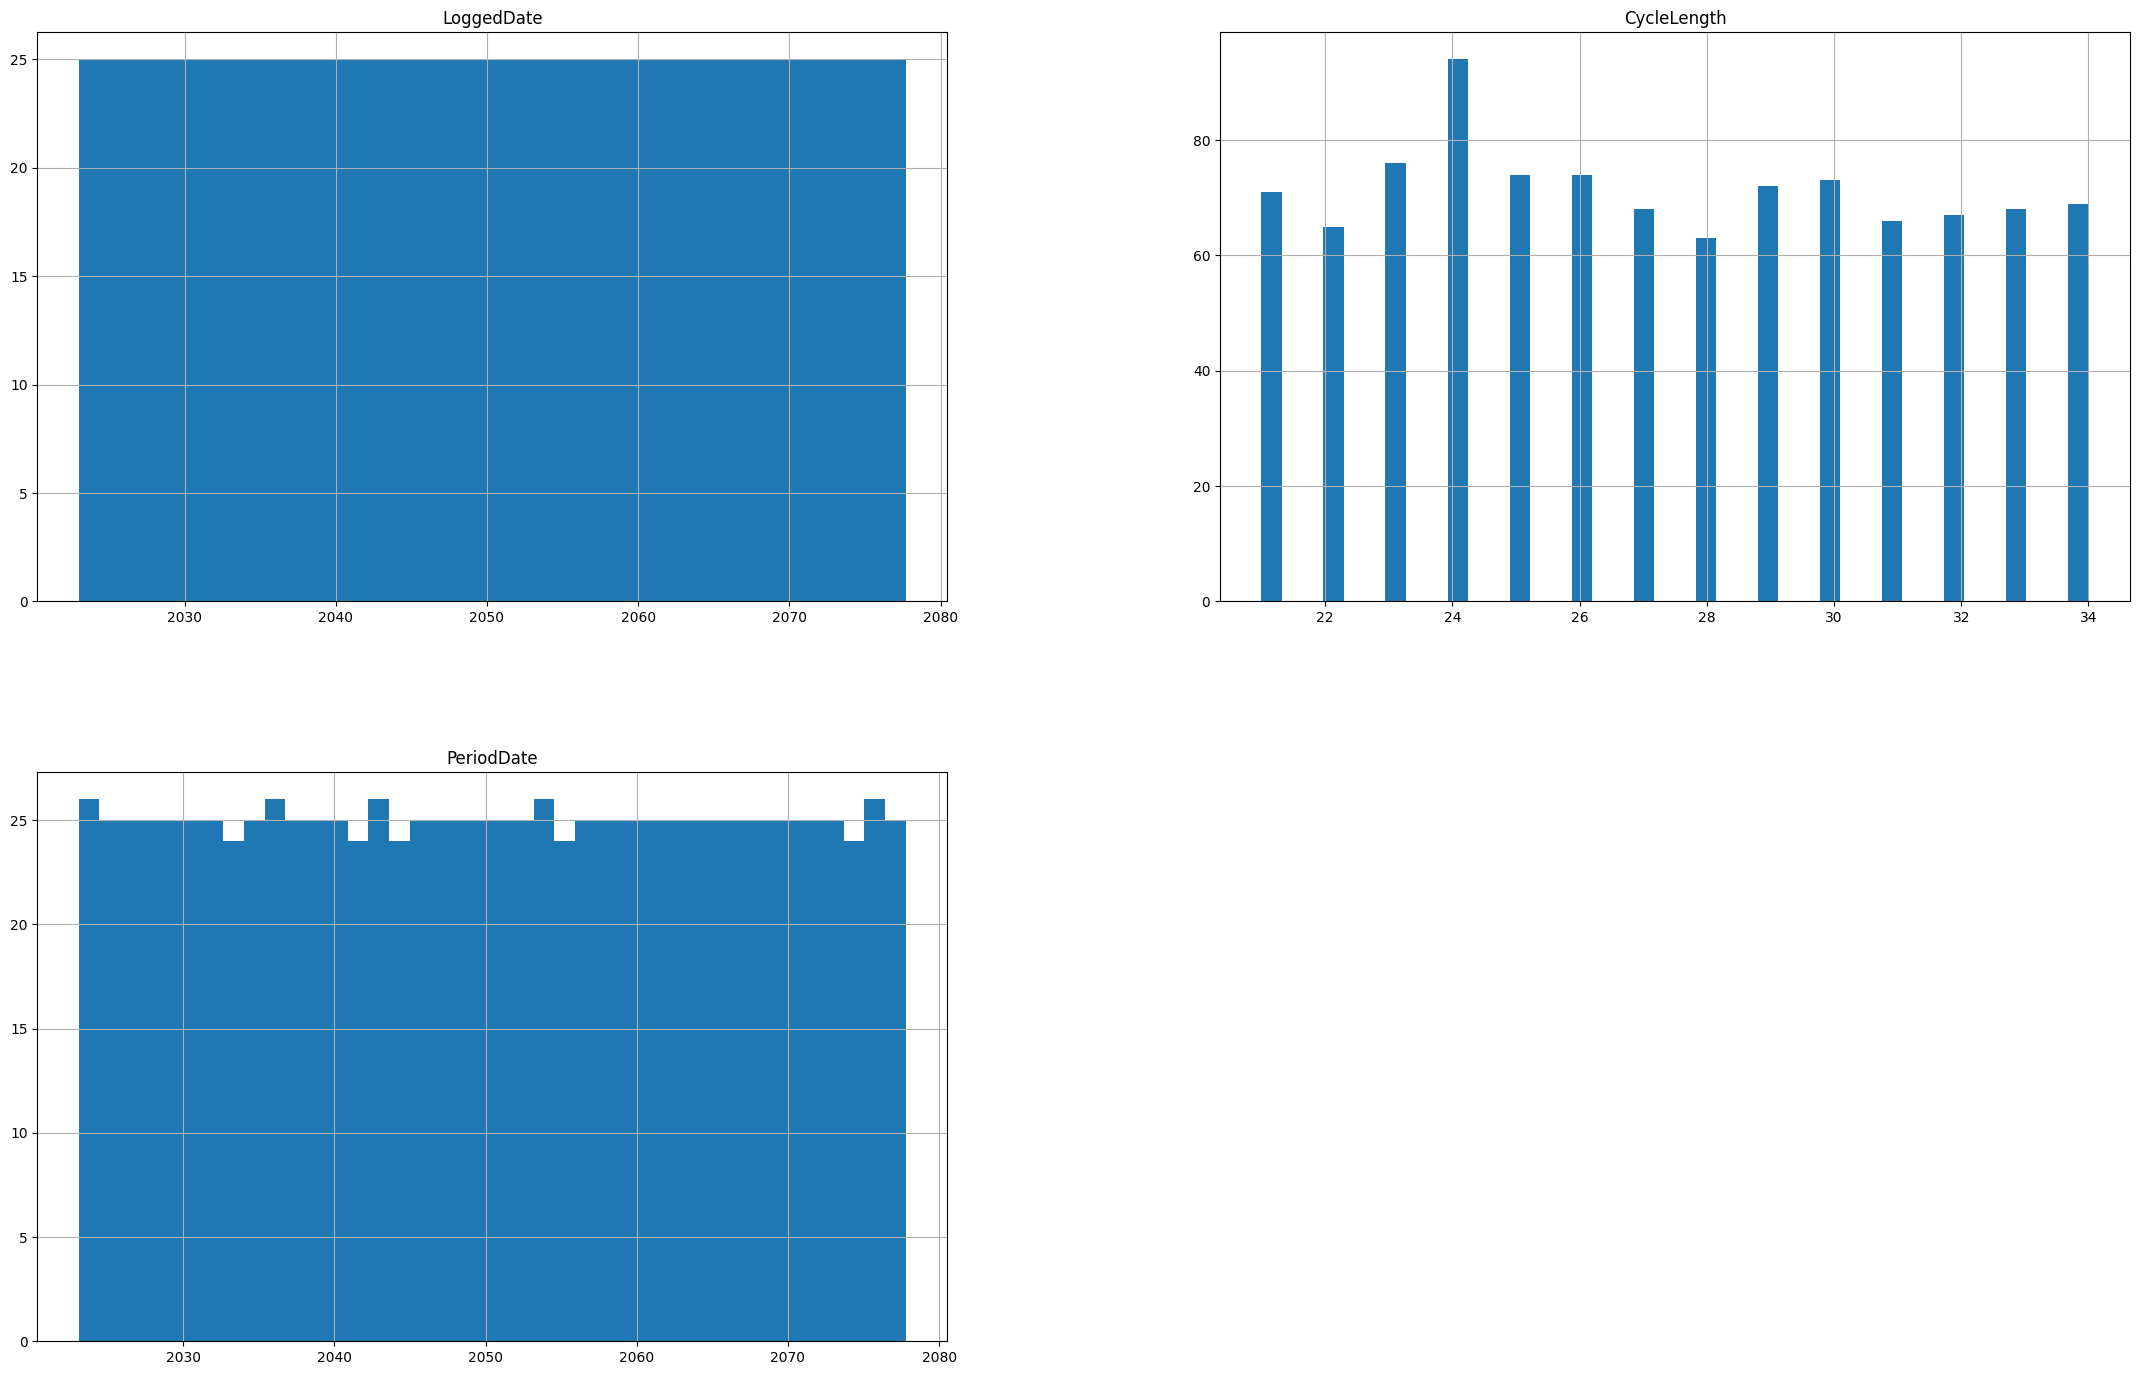

In [6]:
#plot each attribute to check range for scaling
import matplotlib.pyplot as plt
data.hist(bins=40, figsize=(27,17))
plt.show

### Data Splitting

In [7]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

#check correlation range
periodstats_corr =train_set.copy()
correlation = periodstats_corr.corr()
correlation['CycleLength'].sort_values(ascending = False)


/tmp/ipykernel_66383/270512690.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = periodstats_corr.corr()


CycleLength    1.0
Name: CycleLength, dtype: float64

##### The correlation coefficient 1 indicates positive linear relationship between cycle lengths and Period dates.

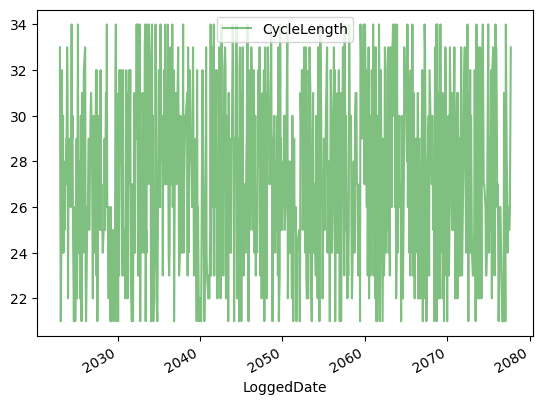

In [8]:
#visualising the correlation
periodstats_corr.plot(kind='line', x='LoggedDate', y='CycleLength', alpha=0.5, color='green')
plt.show()


### Model

In [9]:
y_train = train_set['CycleLength']
X_train = train_set.drop('CycleLength', axis=1)
y_test = test_set['CycleLength']
X_test = test_set.drop('CycleLength', axis=1)

In [10]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
model = rf.fit(X_train, y_train)

In [11]:
# make predictions
prediction = rf.predict(X_train)

### Model Evaluation

In [12]:
from sklearn.metrics import mean_squared_error
import numpy as np
mse = mean_squared_error(y_train, prediction)
mse_2 = np.sqrt(mse)
mse_2

1.8283400941837926

In [13]:
#model validation
from sklearn.model_selection import cross_val_score

# cross validation scores (10 fold cross validation)
cv_scores = cross_val_score(rf, X_train, y_train, cv=10, scoring='neg_mean_squared_error') 


In [14]:
cv_scores = -(cv_scores)  #convert -ve to positive mses
rmse_scores = np.sqrt(cv_scores) # calculating root mean square for each fold
avg_rmse = rmse_scores.mean() # average rmse
#display average rmse
avg_rmse

4.933513730449819

### Fine Tuning

In [15]:
from sklearn.model_selection import GridSearchCV
parameters = [
    {'n_estimators': [100, 200, 300], 'max_features': ['auto', 1, 2, 3]},
    {'bootstrap': [True, False], 'n_estimators': [100, 200, 300], 'max_features': ['auto', 1, 2, 3, 'sqrt']}
]


#grid search
grid_search = GridSearchCV(rf, parameters, cv=5,scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(X_train, y_train)

/home/sunday/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
45 fits failed out of a total of 210.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/home/sunday/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/sunday/.local/lib/python3.10/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/home/sunday/.local/lib/python3.10/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/home/sunday/.loca

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': ['auto', 1, 2, 3],
                          'n_estimators': [100, 200, 300]},
                         {'bootstrap': [True, False],
                          'max_features': ['auto', 1, 2, 3, 'sqrt'],
                          'n_estimators': [100, 200, 300]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [16]:
grid_search.best_params_
{'max_features': 3, 'n_estimators': 10}


{'max_features': 3, 'n_estimators': 10}

### Model Evaluation

In [17]:
# using test set
model2 = grid_search.best_estimator_
prediction2 = model2.predict(X_test)

In [18]:
#root mean squared error on test set
mse__2 = mean_squared_error(y_test, prediction2)
mse_2rt = np.sqrt(mse__2)
mse_2rt

4.864456952676675

##### Performance

In [19]:
# validate model performance using 95% confidence
confidence_interval = 0.95
err_sqr = (prediction2 - y_test)**2

from scipy import stats

np.sqrt(stats.t.interval(confidence_interval, len(err_sqr)-1,loc=err_sqr.mean(),
scale=stats.sem(err_sqr)))

array([4.46647698, 5.23225251])

### Saving The Model

In [20]:
import pickle as pk
#save model
mlmodel = model2
filename = 'mlmodel.pickle'
with open(filename, 'wb') as f:
    pk.dump(mlmodel, f)